In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pandas as pd
from pandas import read_csv

In [2]:
# Create a simple neural network with layer variabliltiy
def neural_net_testing(hidden_nodes=100, layer_num = 0):
    
    layers = [torch.nn.Linear(inputs.shape[1],hidden_nodes),torch.nn.ReLU()]
    for i in range(layer_num):
        layers.append(torch.nn.Linear(hidden_nodes,hidden_nodes))
        layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Linear(hidden_nodes,outputs.shape[1]))
    model = torch.nn.Sequential(*layers)
    # include different number of nodes per layer functionality
    #list with nodes per layer
    return (model.cuda(), hidden_nodes, layer_num)

# Sets error calculations
def abs_err(pred, act):
    return abs(pred-act)
def rel_err(pred, act):
    return abs_err(pred, act)/act
def update_run_data(model, nodes, layers, n_epochs, time_data):
    test_inputs = torch.randn((1000,N),dtype=torch.float32).cuda()
    test_outputs = test_inputs ** 2
    num = 0
    with torch.no_grad():
        model.eval()
        prediction = model(test_inputs)
        for i in list(range(len(prediction))):
            if (abs_err(prediction[i][0], test_outputs[i][0]) < 0.01 or rel_err(prediction[i][0], test_outputs[i][0]) < 0.01):
                num += 1
        run_data.append([(str(nodes)+" nodes"), (str(layers)+" layers"), (str(n_epochs)+" epochs"), (str(time_data)+" seconds"), (str(math.trunc(num/len(test_outputs)*100))+"% accuracy")])
        model_dataset.append(model)
        node_dataset.append(nodes)
        layer_dataset.append(layers)
        n_epoch_dataset.append(n_epochs)
        time_dataset.append(time_data)
        error_dataset.append(str(math.trunc(num/len(test_outputs)*100)))

def run_network(model, num_epochs = 500):
    # Get ready to train
    start_time = time.time()
    model.train()

    # Break the list up into smaller batches for more efficient training
    numMiniBatch = int(math.floor(inputs.shape[0]/100.))
    inputMiniBatches = inputs.chunk(numMiniBatch)
    outputMiniBatches = outputs.chunk(numMiniBatch)

    # Train the neural network
    lossFunc = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

    n_epochs = num_epochs

    loss_vals = []
    loss_epochs = []
    test_loss_vals = []
    test_loss_epochs = []
    accu_vals = []
    accu_epochs = []
    accupts_vals = []
    accupts_epochs = []

    for epoch in range(n_epochs):
        # Print something every 10 epochs of training
        # Plot accuracy every 10 epochs
        if epoch%10 == 0:
            print('=>Starting {}/{} epochs.'.format(epoch+1,n_epochs))

            with torch.no_grad():
                model.eval()
                prediction_temp = model(test_inputs)
                total_num = torch.numel(test_inputs)
                
            model.train()

        for minibatch in range(numMiniBatch):
            prediction = model(inputMiniBatches[minibatch])
            loss = lossFunc(prediction,outputMiniBatches[minibatch])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Plot two points on the loss graph for each epoch, one for testing and one for training.
        with torch.no_grad():
            model.eval()
            total_prediction_temp = model(inputs)
            total_loss_temp = lossFunc(total_prediction_temp, outputs).item()
            test_total_prediction_temp = model(test_inputs)
            test_total_loss_temp = lossFunc(test_total_prediction_temp, test_outputs).item()
            loss_vals = np.append(loss_vals, total_loss_temp)
            loss_epochs = np.append(loss_epochs, epoch)
            test_loss_vals = np.append(test_loss_vals, test_total_loss_temp)
            test_loss_epochs = np.append(test_loss_epochs, epoch)
        model.train()

    #print ('Training done!')
    #print ("--- %s seconds ---" % (time.time() - start_time))
    time_data = (time.time() - start_time)
    return (model, n_epochs, time_data)

In [3]:
# Create a list of sets of N random numbers
N = 3
inputs = (10 * torch.rand((10000,N),dtype=torch.float32) - 5).cuda()
outputs = inputs ** 2
test_inputs = torch.randn((1000,N),dtype=torch.float32).cuda()
test_outputs = test_inputs ** 2

In [4]:
#Generates list of numbers for nodes and layers that multiply to 1000
#Note that any list of nested lists can be passed with the 0 index being nodes and the 1 index being layers
#As long as the layers is less than 255

param_list = []
for i in range(1000):
    if (1000%(i+1) == 0) & (round(1000/(i+1)<155)):
        param_list.append([i+1, round(1000/(i+1))])
#print(param_list)

In [25]:
#Initializes Data Sets

run_data = []
model_dataset = []
node_dataset = []
layer_dataset = []
n_epoch_dataset = []
time_dataset = []
error_dataset = []

In [45]:
# Executes sequence and places data into run_data

#for i in param_list:

list_temp = [[100, 8]]#, [100, 5], [100, 4], [100, 2], [100, 1], [500, 125], [500, 100], [500, 50], [500, 40], [500, 25], [500, 20], [500, 10], [500, 8], [500, 5], [500, 4], [500, 3], [500, 1]]#, [8, 2], [10, 2], [20, 2], [25, 2], [40, 2], [50, 2], [100, 2], [125, 2], [200, 2], [250, 2], [1000, 2]]

for i in list_temp:
    output = neural_net_testing(i[0], i[1])
    model = output[0]
    hidden_nodes = output[1]
    layer_num = output[2]
    output_2 = run_network(model)
    model = output_2[0]
    n_epochs = output_2[1]
    time_data = output_2[2]
    update_run_data(model, hidden_nodes, layer_num, n_epochs, time_data)
# Creates data frame of the data
data_dict = {"Nodes":node_dataset, "Layers":layer_dataset, "Epochs":n_epoch_dataset, "Time":time_dataset, "Accuracy %":error_dataset}
df = pd.DataFrame(data=data_dict)
print(run_data)
print ('Training done!')

In [27]:
data_dict = {"Nodes":node_dataset, "Layers":layer_dataset, "Epochs":n_epoch_dataset, "Time":time_dataset, "Accuracy %":error_dataset}
df = pd.DataFrame(data=data_dict)

In [30]:
print(df)

     Nodes  Layers  Epochs         Time  Accuracy %
0      8.0   125.0   500.0  2109.106663         0.0
1     10.0   100.0   500.0  1602.320417         0.0
2     20.0    50.0   500.0   901.471942         4.0
3     25.0    40.0   500.0   762.617880         1.0
4     40.0    25.0   500.0   519.008795         1.0
5     50.0    20.0   500.0   420.338205         1.0
6    100.0    10.0   500.0   237.778120        18.0
7    125.0     8.0   500.0   185.446167        32.0
8    200.0     5.0   500.0   126.881377        33.0
9    250.0     4.0   500.0   107.282485        46.0
10   500.0     2.0   500.0    69.688906        88.0
11  1000.0     1.0   500.0    45.948215         0.0


In [33]:
#uploads existing data and adds it to working dataset
#file_upload = read_csv("NN_Test_Data_1.csv")
#print(file_upload)
#df = df.append(file_upload)

In [16]:
df=df.astype(float)

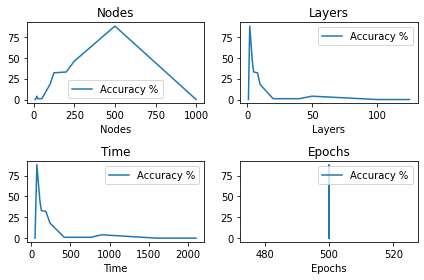

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2)

df.plot(x="Nodes",y="Accuracy %", ax=axes[0,0]); axes[0,0].set_title('Nodes')

df.plot(x="Layers",y="Accuracy %", ax=axes[0,1]); axes[0,1].set_title('Layers')

df.plot(x="Time",y="Accuracy %", ax=axes[1,0]); axes[1,0].set_title('Time')

df.plot(x="Epochs",y="Accuracy %", ax=axes[1,1]); axes[1,1].set_title('Epochs')

plt.tight_layout()

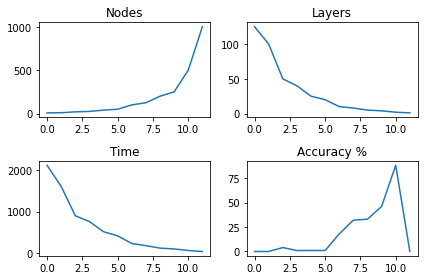

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2)

df['Nodes'].plot(ax=axes[0,0]); axes[0,0].set_title('Nodes')

df['Layers'].plot(ax=axes[0,1]); axes[0,1].set_title('Layers')

df['Time'].plot(ax=axes[1,0]); axes[1,0].set_title('Time')

df['Accuracy %'].plot(ax=axes[1,1]); axes[1,1].set_title('Accuracy %')

plt.tight_layout()

In [ ]:
#Saves run data as csv file
#df.to_csv("NN_Test_Data_1.csv", index=False)